In [1]:
import os
import csv
import pandas as pd
import time
import pickle
import sys
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


In [2]:
print(os.getcwd())
# it should end with this: /AITutor_SeqModeling
# if not, run the next block


/Users/pedram/Projects/GitMyself/AITutor_SeqModeling/KnowledgeTracking


In [3]:
# run if the current directory is not AITutor_SeqModeling
cwd = os.chdir(os.path.join(os.getcwd(), ".."))
print(os.getcwd())

/Users/pedram/Projects/GitMyself/AITutor_SeqModeling


In [4]:
# download the groups as a set
a = pd.read_csv("data/Groups.csv")
valid_ids = set(a["id"].values)
len(valid_ids)

89

In [5]:
File_pickle = "data/KT_logs_annotated.pkl"

# read from pickle
df = pd.read_pickle(File_pickle)

df.head()

,username,skill,correct,time
0,a1,"[Supervised Learning, Classification Algorithms]",True,0.000000
1,a1,"[Supervised Learning, Classification Algorithms]",False,3.726700
2,a2,"[Supervised Learning, Classification Algorithms]",False,0.000000
3,a2,"[Supervised Learning, Classification Algorithms]",True,1.987467
4,a3,"[Supervised Learning, Classification Algorithms]",True,0.000000


In [6]:
# get the number of unique usernames
len(df["username"].unique())

93

In [7]:
# get rid of entries where username is not in the valid_ids
df = df[df["username"].isin(valid_ids)]
len(df["username"].unique())

89

In [8]:
skills = pickle.load(open("data/Skill_hirereachy.pkl", "rb"))

In [9]:
# version 1: Only user params
# user_params = {}

# def initialize_user_params(user_id, skills):
#     user_params[user_id] = {}
#     for skill in skills.keys():
#         skill_params = skills[skill][-1]
#         user_params[user_id][skill] = {
#             "P(L)": skill_params[0],
#             "P(T)": skill_params[1],
#             "P(G)": skill_params[2],
#             "P(S)": skill_params[3]
#         }
# for user_id in df["username"].unique():
#     initialize_user_params(user_id, skills)

In [10]:
# version 2: seperate user-specific and skill specific parameters
def initialize_params(skills, user_ids):
    user_params = defaultdict(dict)
    skill_params = {}
    for skill in skills.keys():
        skill_params[skill] = {
                "P(L)": skills[skill][-1][0],
                "P(T)": skills[skill][-1][1],
                "P(G)": skills[skill][-1][1],
                "P(S)": skills[skill][-1][3]
            }
        for user_id in user_ids:
            # assume all users have the same initial skill level
            # add prior knowledge here if exists
            for skill in skills.keys():
                user_params[user_id][skill] =  {
                    "P(L)": skills[skill][-1][0],
                    "P(T)": skills[skill][-1][1],
                    "P(G)": skills[skill][-1][1],
                    "P(S)": skills[skill][-1][3]
                }
            user_params[user_id]['weight'] = 0.5
    return skill_params, user_params

In [11]:
skill_params, user_params = initialize_params(skills,  df["username"].unique())
user_params['a1']["weight"]

0.5

In [12]:
# Function to compute P(C_t|L_t, G, S)
def compute_prob_correctness(P_L, P_G, P_S, P_T, correct):
    if correct:
        P_L_obs = P_L* (1 - P_S) /((1 - P_S) * P_L + P_G * (1 - P_L))
    else:
        P_L_obs = P_L* (P_S) /(P_S * P_L + (1 - P_G) * (1 - P_L))
    
    P_L_new = P_L_obs + (1 - P_L_obs) * P_T
    P_C = P_L_new * (1 - P_S) + (1 - P_L_new) * P_G

    # debug
    if not (0 <= P_C <= 1):
        print(f"Invalid P(C): {P_C}, P_L: {P_L}, P_G: {P_G}, P_S: {P_S}, P_T: {P_T}")
    return P_C, P_L_new


In [13]:
def compute_gradients(P_tuple, correct):

    P_L, P_G, P_S, P_T = P_tuple
    if correct:
        dP_L_obs_dP_L = (1 - P_S) * ((1 - P_S) - P_G) / (((1 - P_S) * P_L + P_G * (1 - P_L)) ** 2)
    else:
        dP_L_obs_dP_L = P_S * (P_S - (1 - P_G)) / ((P_S * P_L + (1 - P_G) * (1 - P_L)) ** 2)

    P_L_obs = P_L * P_S / (P_S * P_L + (1 - P_G) * (1 - P_L))
    P_L_new = P_L_obs + (1 - P_L_obs) * P_T
    
    
    dP_L_new_dP_L = dP_L_obs_dP_L * (1 - P_T)
    dP_C_dP_L = dP_L_new_dP_L * (1 - P_S) - dP_L_new_dP_L * P_G

    dP_L_new_dP_T = 1 - (P_L_obs if correct else 0)
    dP_C_dP_T = dP_L_new_dP_T * (1 - P_S) - dP_L_new_dP_T * P_G

    dP_C_dP_G = (1 - P_L_new) - P_L_new
    dP_C_dP_S = -P_L_new + P_G * (1 - P_L_new)

    return dP_C_dP_L, dP_C_dP_T, dP_C_dP_G, dP_C_dP_S

In [14]:
def log_likelihood(interaction_log, skill_params, user_params):
    log_likelihood = 0
    expectations = []
    skill_counts = defaultdict(int)
    user_counts = defaultdict(int)
    for _, row in interaction_log.iterrows():
        user_id = row["username"]
        skill_list = row["skill"]
        correctness = row["correct"]

        for skill in skill_list:
            P_L_user = user_params[user_id][skill]["P(L)"]
            P_G_user = user_params[user_id][skill]["P(G)"]
            P_S_user = user_params[user_id][skill]["P(S)"]
            P_T_user = user_params[user_id][skill]["P(T)"]

            P_L_skill = skill_params[skill]["P(L)"]
            P_G_skill = skill_params[skill]["P(G)"]
            P_S_skill = skill_params[skill]["P(S)"]
            P_T_skill = skill_params[skill]["P(T)"]


            weight = user_params[user_id]['weight']

            P_L = weight * P_L_user + (1 - weight) * P_L_skill
            P_G = weight * P_G_user + (1 - weight) * P_G_skill
            P_S = weight * P_S_user + (1 - weight) * P_S_skill
            P_T = weight * P_T_user + (1 - weight) * P_T_skill

            # update skill and user counts
            skill_counts[skill] += 1
            user_counts[user_id] += 1

            prob, _ = compute_prob_correctness(P_L, P_G, P_S, P_T, correctness)
            log_likelihood += np.log(prob + 1e-9)
            expectations.append((user_id, skill, prob, correctness, (P_L, P_G, P_S, P_T)))

    return -log_likelihood, expectations, skill_counts, user_counts

In [15]:
def expectation_step(interaction_log, skill_params, user_params):
    skill_grads = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    user_grads = defaultdict(lambda: defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0}))
    weight_grads = {user_id: 0 for user_id in user_params.keys()}
    loss = 0
    log = {}
    log["skill"] = defaultdict(list)
    log["user"] = defaultdict(list)
    likelihood, expectations, skill_counts, user_counts = log_likelihood(interaction_log, skill_params, user_params)
    if np.isnan(likelihood):
        print("Log-likelihood NaN detected! Check parameter updates.")

    for user_id, skill, prob, correctness,  P_tuple  in expectations:
        log["skill"][skill].append(prob)
        log["user"][user_id].append(prob)
        dP_C_dP_L, dP_C_dP_T, dP_C_dP_G, dP_C_dP_S = compute_gradients(P_tuple, correctness)
        grad = (correctness - prob) / (prob + 1e-9)
        loss += (correctness - prob) ** 2

        # Update user-specific gradients
        w = user_params[user_id]['weight']
        normalizing_factor = user_counts[user_id]/len(skill_counts)
        
        user_grads[user_id][skill]["P(L)"] += grad * dP_C_dP_L* w / normalizing_factor
        user_grads[user_id][skill]["P(G)"] += grad * dP_C_dP_G* w / normalizing_factor
        user_grads[user_id][skill]["P(S)"] += grad * dP_C_dP_S* w / normalizing_factor
        user_grads[user_id][skill]["P(T)"] += grad * dP_C_dP_T* w / normalizing_factor

        # gradient of weights
        weight_grads[user_id] += grad *( (user_params[user_id][skill]["P(L)"] - skill_params[skill]["P(L)"]) * dP_C_dP_L + \
                                     (user_grads[user_id][skill]["P(T)"] - skill_params[skill]["P(T)"]) * dP_C_dP_T + \
                                    (user_grads[user_id][skill]["P(G)"] - skill_params[skill]["P(G)"]) * dP_C_dP_G + \
                                     (user_grads[user_id][skill]["P(S)"] - skill_params[skill]["P(S)"]) * dP_C_dP_S)
        

        # Update skill-specific gradients
        normalizing_factor = skill_counts[skill]*user_counts[user_id]
        skill_grads[skill]["P(L)"] += grad * dP_C_dP_L * (1 - w) / normalizing_factor
        skill_grads[skill]["P(G)"] += grad * dP_C_dP_G * (1 - w)/ normalizing_factor
        skill_grads[skill]["P(S)"] += grad * dP_C_dP_S * (1 - w)/ normalizing_factor
        skill_grads[skill]["P(T)"] += grad * dP_C_dP_T * (1 - w)/ normalizing_factor

        
    

    return skill_grads, user_grads, weight_grads, likelihood, loss, log

In [16]:
# Parent-Child Constraints
def enforce_constraints(user_params, skill_params, skills):
    for skill, skill_data in skills.items():
        parents = skill_data[1]
        for parent in parents:
            if skill_params[skill]["P(L)"] >= skill_params[parent]["P(L)"]:
                skill_params[skill]["P(L)"] = skill_params[parent]["P(L)"] - 0.01 
            for user in user_params:
                parent_prob = user_params[user][parent]["P(L)"]
                child_prob = user_params[user][skill]["P(L)"]
                if child_prob >= parent_prob:
                    user_params[user][skill]["P(L)"] = parent_prob - 0.01  # Apply heuristic

In [17]:
# Projection
def project_params(params, par_type):
    for key, param_set in params.items():
        if  par_type == "user":
                for skill, ps in param_set.items():
                    if skill == 'weight':
                        params[key][skill] = np.clip(params[key][skill], 0, 1)
                    else:
                        for param in ps:
                            params[key][skill][param] = np.clip(params[key][skill][param], 0, 1)
        elif par_type == "skill":
            for param in param_set:
                params[key][param] = np.clip(params[key][param], 0, 1)
        else:
            raise ValueError("Invalid parameter type. Must be 'user' or 'skill'.")
            
    return params

In [18]:
# M-Step: Update parameters
def maximization_step(skill_params, user_params, skill_grads, user_grads, weight_grads, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1, reg_lambda=0.01, iteration=0):
    # Adam accumulators
    skill_m = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    skill_v = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    user_m = defaultdict(lambda: defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0}))
    user_v = defaultdict(lambda: defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0}))
    output = defaultdict(list) # for plotting


    # Apply batch updates for skill-specific parameters
    for skill, grads in skill_grads.items():
        for param, grad in grads.items():
            # skill_params[skill][param] += learning_rate * grad
            m = skill_m[skill][param]
            v = skill_v[skill][param]

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            # skill_params[skill][param] = np.clip(skill_params[skill][param] + 10*learning_rate * m_hat / (np.sqrt(v_hat) + epsilon), 0, 1)
            if iteration>50:
                 multi = 200
            else:
                 multi = 300
            skill_params[skill][param] = np.clip(skill_params[skill][param] + 400*learning_rate * grad , 0, 1)
            skill_m[skill][param] = m
            skill_v[skill][param] = v

    # Apply SGD for user-specific updates
    for user_id, skills in user_grads.items():
        for skill, grads in skills.items():
            for param, grad in grads.items():

                    # user_params[user_id][skill][param] += learning_rate * grad
                    m = user_m[user_id][skill][param]
                    v = user_v[user_id][skill][param]

                    m = beta1 * m + (1 - beta1) * grad
                    v = beta2 * v + (1 - beta2) * (grad ** 2)
                    m_hat = m / (1 - beta1 ** t)
                    v_hat = v / (1 - beta2 ** t)

                    # regulirizer
                    reg = reg_lambda * (skill_params[skill][param]-user_params[user_id][skill][param])

                    user_params[user_id][skill][param] = np.clip(
                        #  user_params[user_id][skill][param] + 0.015*learning_rate * (grad+reg),0, 1)
                    user_params[user_id][skill][param] + learning_rate * (m_hat + reg) / (np.sqrt(v_hat) + epsilon),0, 1)
                    user_m[user_id][skill][param] = m
                    user_v[user_id][skill][param] = v

    
            
    # Update user weights
    if iteration > 20:
        for user_id in user_params.keys():
            user_params[user_id]['weight'] =np.clip(user_params[user_id]['weight'] -0.05*learning_rate * weight_grads[user_id], 0, 1)
    # logging
    output["weight"] = [user_params[user_id]['weight'] for user_id in user_params.keys()]
    output["P(L)"] = [skill_params[skill]["P(L)"] for skill in skill_params.keys()]
    output["PL_user"] = [user_params[list(user_params.keys())[0]][list(skill_params.keys())[2]]["P(L)"], #user 1, skill 3
                         user_params[list(user_params.keys())[5]][list(skill_params.keys())[2]]["P(L)"], #user 6, skill 3
                          user_params[list(user_params.keys())[5]][list(skill_params.keys())[5]]["P(L)"], # user 6, skill 6
                           user_params[list(user_params.keys())[15]][list(skill_params.keys())[7]]["P(L)"] ] # user 16, skill 8

    return skill_params, user_params, output

In [19]:
def run_em_with_sgd(interaction_log, skills, max_iter, learning_rate, reg_lambda):
    skill_params, user_params = initialize_params(skills, interaction_log["username"].unique())
    log =defaultdict(list)
    pt = 0

    for i in range(max_iter):
        log["iteration"].append(i)
        skill_grads, user_grads, weight_grads, likelihood, loss, out_e = expectation_step(interaction_log, skill_params, user_params)
        # decrease the learning rate to half after every 40 iterations
        pt += 1
        if i>10 and pt>5 and loss > log["loss"][-1]:
            pt = 0
            learning_rate /= 2
            print(f"Learning rate halved")
        skill_params, user_params, out_m = maximization_step(skill_params, user_params, skill_grads, user_grads, weight_grads,learning_rate=learning_rate, reg_lambda = reg_lambda, iteration=i)
        log["weight_avg"].append(np.average(out_m["weight"]))
        log["weight"].append(np.array(out_m["weight"]))
        log["P_L"].append(out_m["P_L"])
        log["P_LU"].append(out_m["PL_user"])
        log["likelihood"].append(likelihood)
        log["loss"].append(loss)
        log["E_skill"].append(out_e["skill"])
        log["E_user"].append(out_e["user"])
        skill_params = project_params(skill_params, "skill")
        user_params = project_params(user_params, "user")
        if i % 5 == 0:
            print(f"Iteration {i + 1}, Log-likelihood: {likelihood}, Loss: {loss}")

    return skill_params, user_params, log

Iteration 1, Log-likelihood: 18977.88554156362, Loss: 2243.8420045456405
Iteration 6, Log-likelihood: 20742.466380965623, Loss: 2006.2001466924407
Iteration 11, Log-likelihood: 23036.496369327135, Loss: 1796.4144242316988
Iteration 16, Log-likelihood: 25880.09801883316, Loss: 1613.6940364154361
Iteration 21, Log-likelihood: 27767.267088806297, Loss: 1459.5783012889292
Iteration 26, Log-likelihood: 29266.961120280008, Loss: 1360.4409710123277
Iteration 31, Log-likelihood: 31151.197858786036, Loss: 1261.475291284785
Iteration 36, Log-likelihood: 34186.89808227999, Loss: 1158.786913138368
Iteration 41, Log-likelihood: 36975.22981316765, Loss: 1061.9720367498694
Iteration 46, Log-likelihood: 39186.53525381881, Loss: 973.388243391534
Iteration 51, Log-likelihood: 40656.00383477996, Loss: 897.0650488362063
Iteration 56, Log-likelihood: 41968.87779108317, Loss: 835.4298026177254
Iteration 61, Log-likelihood: 42214.29935207815, Loss: 789.5205885704918
Iteration 66, Log-likelihood: 41968.330720

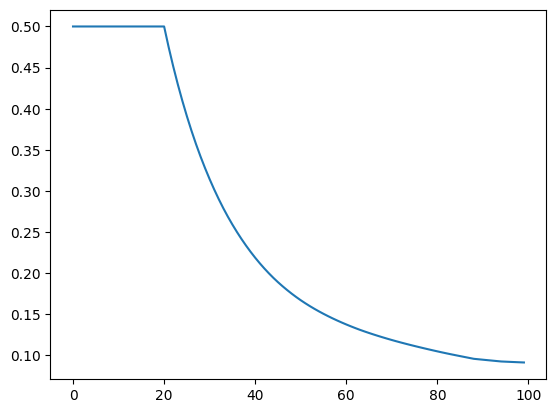

In [20]:
# Run the EM Algorithm
skill_params, user_params, log = run_em_with_sgd(df.iloc[:], skills, max_iter=100, learning_rate=5e-3, reg_lambda=0 )

# plot average of weights for each epoch
plt.plot(log["iteration"], log["weight_avg"])

# Output Results
print("Final Skill Parameters:")
for skill, params in skill_params.items():
    print(skill, params)

print("\nFinal User Parameters:")
for user_id, user_data in user_params.items():
    print(user_id)
    for skill, params in user_data.items():
        print(f"  {skill}: {params}")

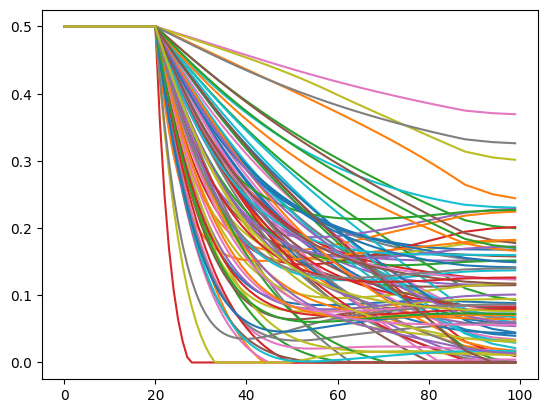

In [21]:
plt.plot(log["iteration"], log["weight"])

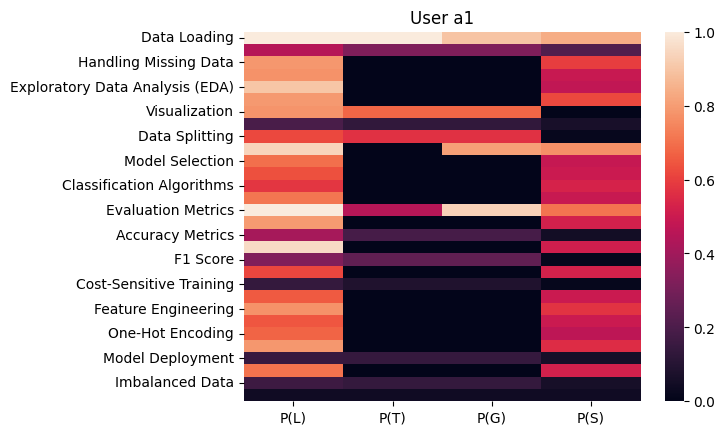

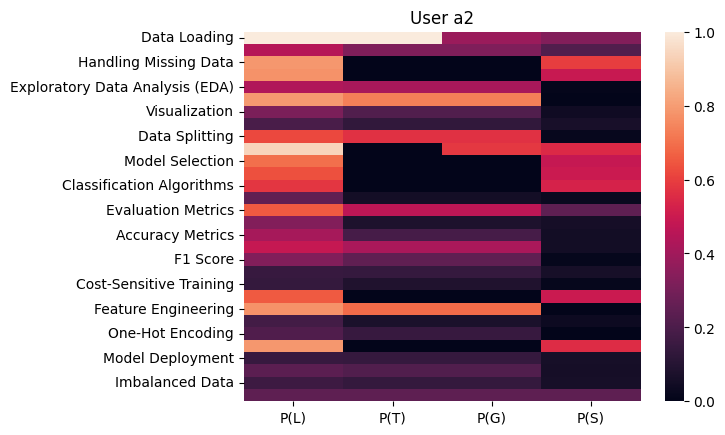

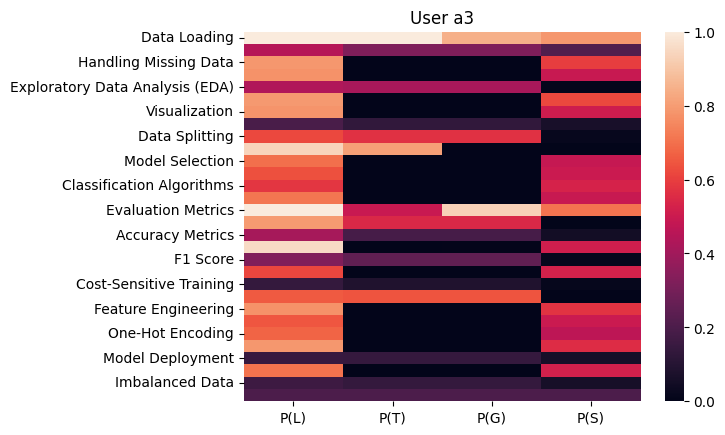

In [22]:
# create heatmap for the first 3 users and compare with skill parameters
for user_id in df["username"].unique()[:3]:
    user_data = user_params[user_id]
    user_df = pd.DataFrame(user_data).T
    sns.heatmap(user_df, annot=False)
    plt.title(f"User {user_id}")
    plt.show()


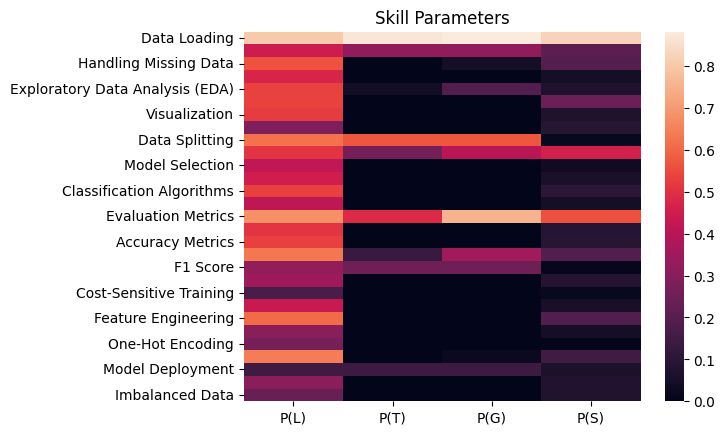

In [23]:
# create heatmap for the skill set parameter
skill_df = pd.DataFrame(skill_params).T
sns.heatmap(skill_df, annot=False)
plt.title("Skill Parameters")
plt.show()

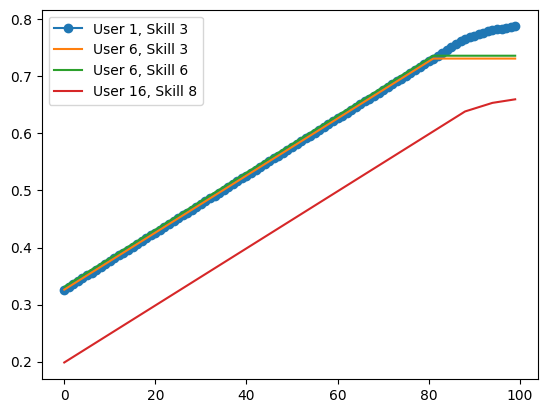

In [24]:
# plot the   first row of the log(P_L) for differnt iteration over interaction
plt.figure()
labels = ['User 1, Skill 3', 'User 6, Skill 3', 'User 6, Skill 6', 'User 16, Skill 8']
for j in range(4):
  y = [log["P_LU"][i][j] for i in range(0,100)]
  if j == 0:
    plt.plot(log["iteration"], y, label=labels[j], marker='o')
  else:
    plt.plot(log["iteration"], y, label=labels[j])
# show the labels
plt.legend()
plt.show()

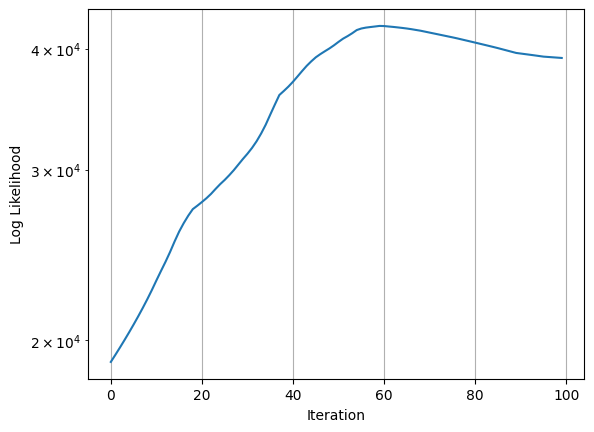

In [25]:
# plot the log likelihood in log scale
plt.figure()
plt.plot(log["iteration"], log["likelihood"])
plt.yscale('log')
plt.grid()
plt.ylabel('Log Likelihood')
plt.xlabel('Iteration')
plt.show()


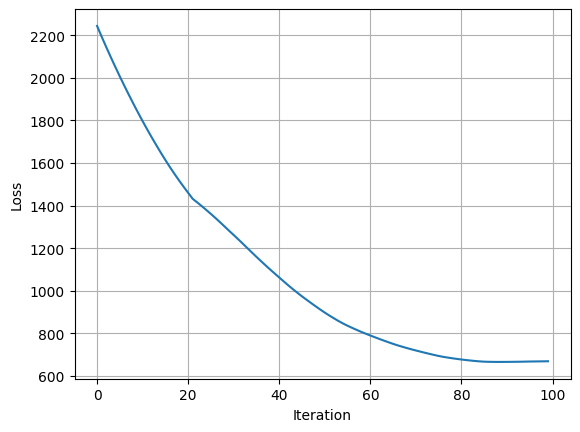

In [26]:
# plot the loss of correctness over iteration
plt.figure()
plt.plot(log["iteration"], log["loss"])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

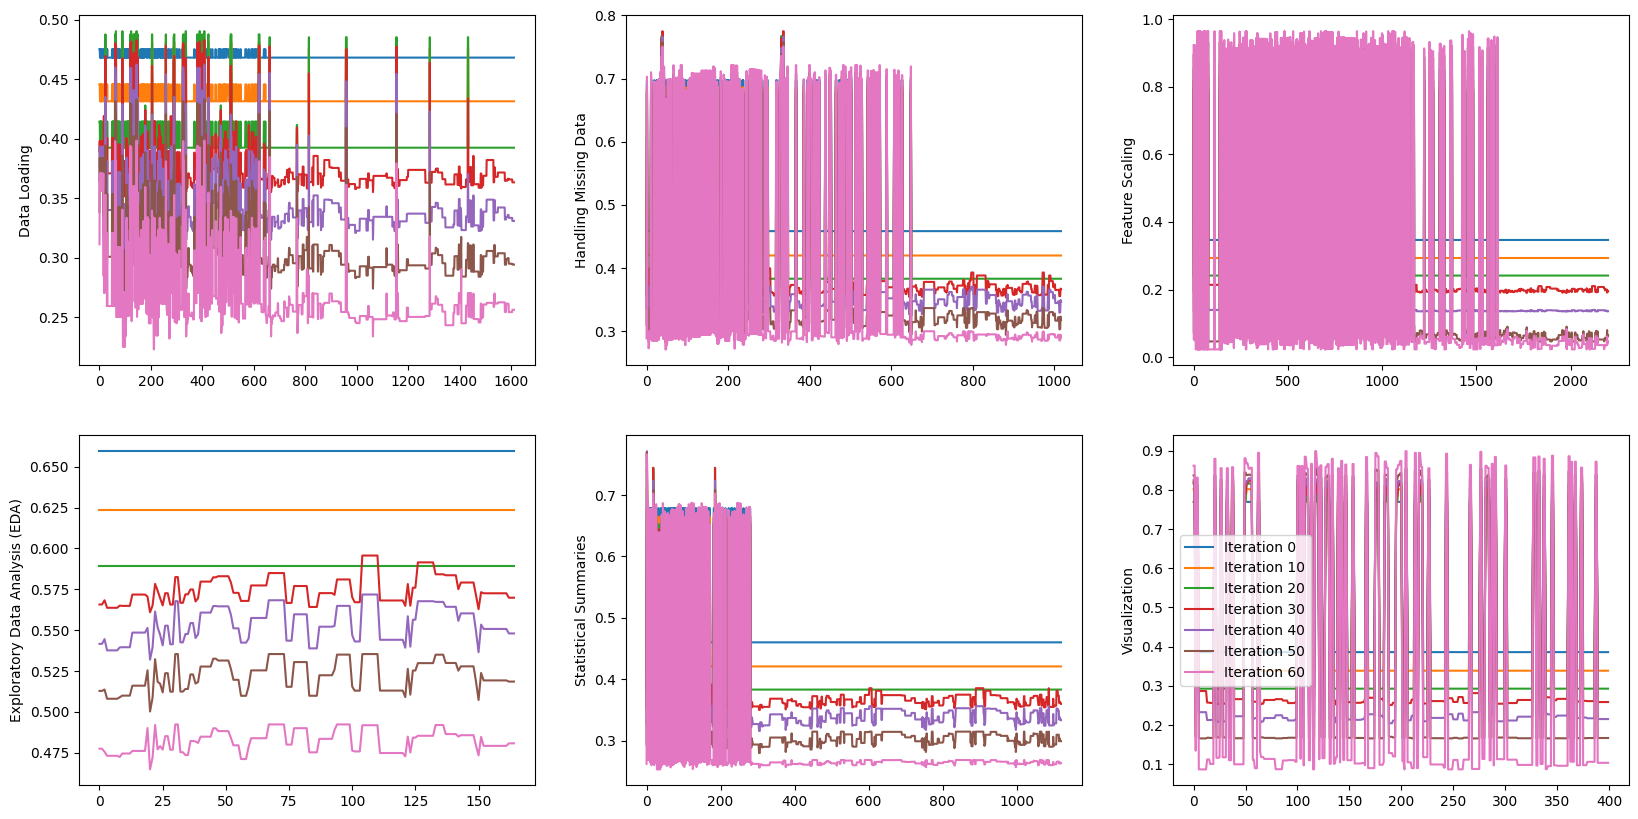

In [27]:
# plot 6 skill over time for different iterations
plt.figure(figsize=(20, 10))
for i in range(0, 70, 10):
    plt.subplot(2, 3, 1)
    skill1 = list(skill_params.keys())[0]
    plt.plot(log["E_skill"][i][skill1])
    plt.ylabel(skill1)
    plt.subplot(2, 3, 2)
    skill2 = list(skill_params.keys())[2]
    plt.plot(log["E_skill"][i][skill2])
    plt.ylabel(skill2)
    plt.subplot(2, 3, 3)
    skill3 = list(skill_params.keys())[3]
    plt.plot( log["E_skill"][i][skill3])
    plt.ylabel(skill3)
    plt.subplot(2, 3, 4)
    skill4 = list(skill_params.keys())[4]
    plt.plot( log["E_skill"][i][skill4])
    plt.ylabel(skill4)
    plt.subplot(2, 3, 5)
    skill5 = list(skill_params.keys())[5]
    plt.plot( log["E_skill"][i][skill5])
    plt.ylabel(skill5)
    plt.subplot(2, 3, 6)
    skill6 = list(skill_params.keys())[6]
    plt.plot( log["E_skill"][i][skill6], label = f"Iteration {i}")
    plt.ylabel(skill6)
plt.legend()
plt.show()

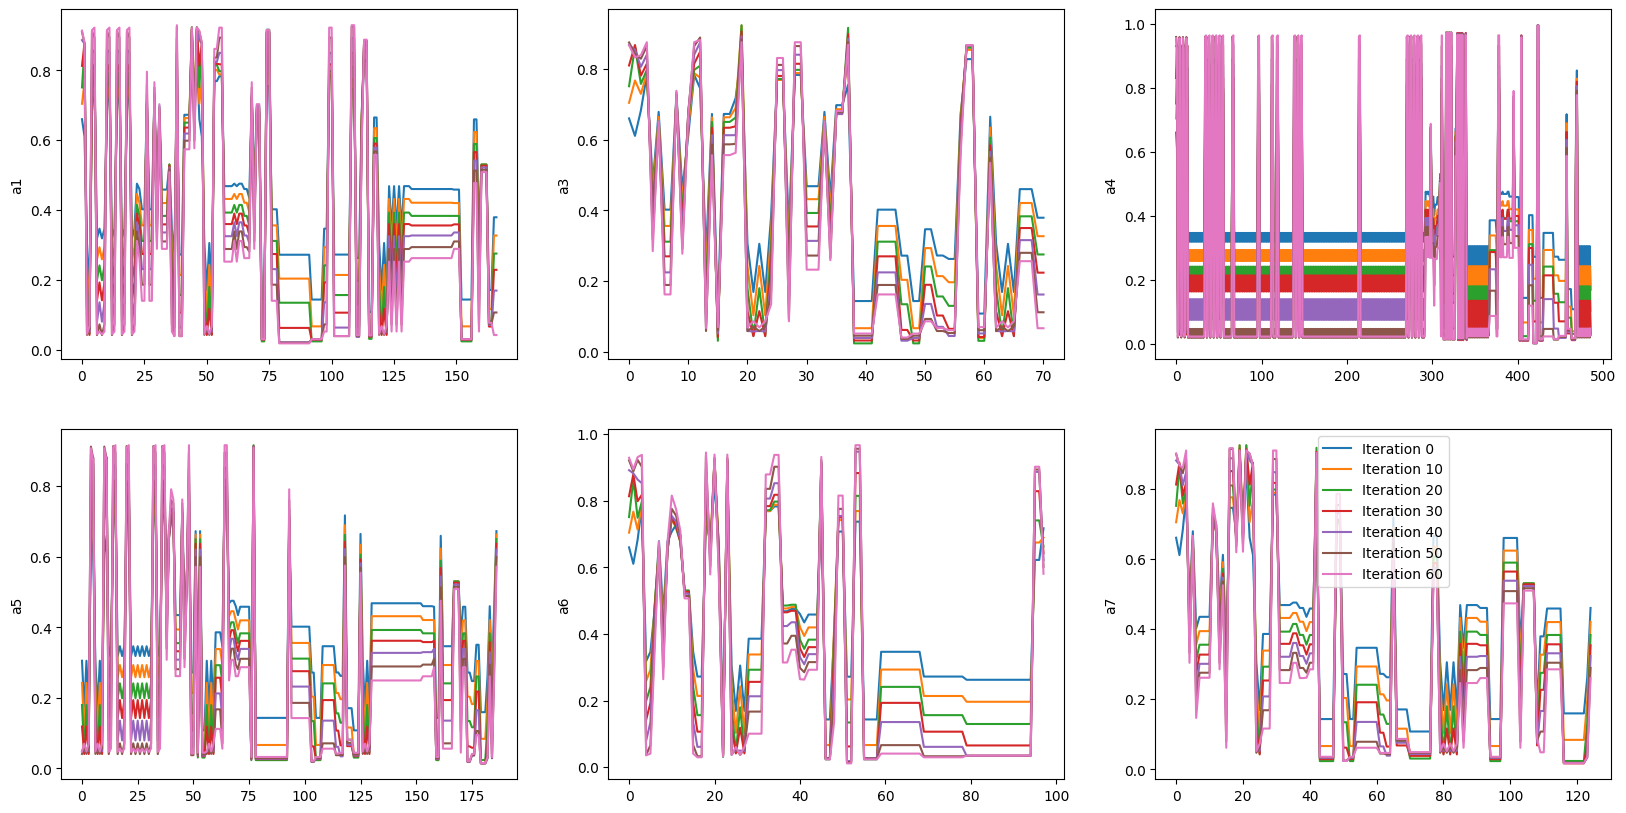

In [28]:
# plot 6 skill over time for different iterations
plt.figure(figsize=(20, 10))
for i in range(0, 70, 10):
    plt.subplot(2, 3, 1)
    user1 = list(user_params.keys())[0]
    plt.plot(log["E_user"][i][user1])
    plt.ylabel(user1)
    plt.subplot(2, 3, 2)
    user2 = list(user_params.keys())[2]
    plt.plot(log["E_user"][i][user2])
    plt.ylabel(user2)
    plt.subplot(2, 3, 3)
    user3 = list(user_params.keys())[3]
    plt.plot( log["E_user"][i][user3])
    plt.ylabel(user3)
    plt.subplot(2, 3, 4)
    user4 = list(user_params.keys())[4]
    plt.plot( log["E_user"][i][user4])
    plt.ylabel(user4)
    plt.subplot(2, 3, 5)
    user5 = list(user_params.keys())[5]
    plt.plot( log["E_user"][i][user5])
    plt.ylabel(user5)
    plt.subplot(2, 3, 6)
    user6 = list(user_params.keys())[6]
    plt.plot( log["E_user"][i][user6], label = f"Iteration {i}")
    plt.ylabel(user6)
plt.legend()
plt.show()